# Log Likelihood Debugging
Getting weird values for log likelihood when we extend p to be 0 and 1 beyond the bins that have persons in them.

In [635]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import logging
import matplotlib.pyplot as plt
import nirt.simulate.simulate_data; import nirt.simulate.plot_irf
import nirt.solver
import numpy as np
import scipy.optimize

%load_ext autoreload
%autoreload 2

for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [636]:
np.random.seed(0)

# Number of persons.
P = 100
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Using 2-PL model with fixed discrimination and no asymptote for all items.
x, theta, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=0, discrimination=1)

In [637]:
# Build an IRF from some reasonable theta values.
num_bins = 10
sample_size = 200
theta = nirt.likelihood.initial_guess(x, c)
sample = np.random.choice(np.arange(P, dtype=int), size=min(P, sample_size), replace=False)
grid = [nirt.grid.Grid(theta[sample, d], num_bins) for d in range(C)]
irf = [nirt.irf.ItemResponseFunction(grid[c[i]], x[:, i]) for i in range(I)]

In [638]:
items = np.where(c == d)[0]
print('d', d, 'items', items)

d 0 items [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


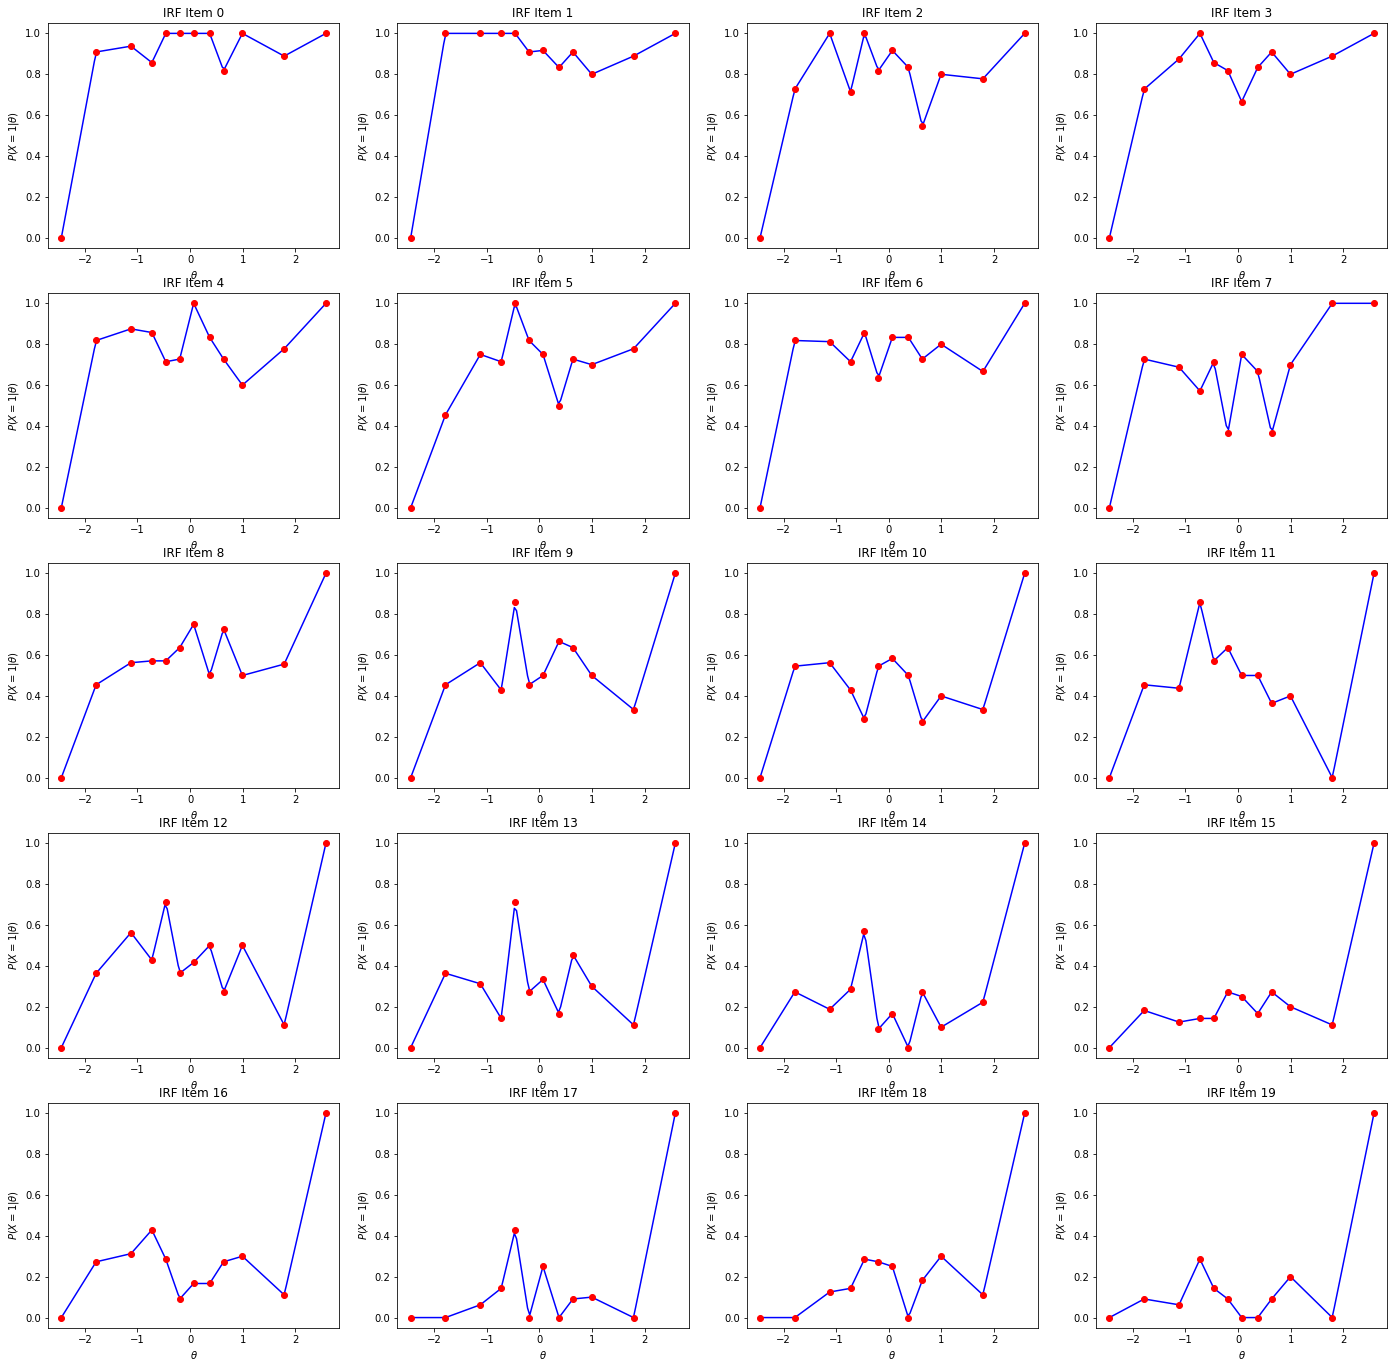

In [639]:
fig, axs = plt.subplots(len(items) // 4, 4, figsize=(24, 24))
for k, item in enumerate(items):
    ax = axs[k // 4, k % 4]
    irf[k].plot(ax, title="IRF Item {}".format(k))
    
# ax = plt.gca()
# k = I - 1
# irf[k].plot(ax, title="Item {}".format(k))
# ax.grid(True)

# print(irf[k].count)
# print(irf[k].probability)

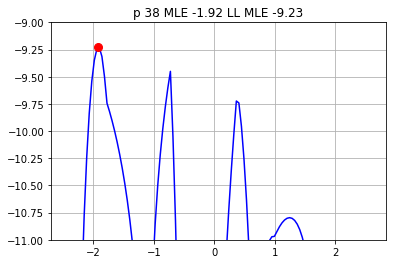

In [640]:
likelihood = nirt.likelihood.Likelihood(x, c, grid, irf)
d = 0

p_values = [38] #range(5)
fig, axs = plt.subplots(1, len(p_values)) #, figsize=(20, 3))
for p in p_values:
    i = np.where(c == d)[0][0]
    t = np.linspace(irf[i].x[0], irf[i].x[-1], 10 * len(irf[i].x) + 1)
    active = np.tile([p, d], (len(t), 1))
    likelihood_values = likelihood.log_likelihood_term(t, active=(active[:, 0], active[:, 1]))

    # Verify that we can find the LL maximum with a root finder.
    t_mle = likelihood.parameter_mle(p, d, max_iter=10)
    likelihood_mle = likelihood.log_likelihood_term(t_mle, (np.array([p]), np.array([d])))[0]

    ax = axs if len(p_values) == 1 else axs[p]
    ax.plot(t, likelihood_values, 'b-')
    ax.grid(True)
    ax.set_ylim([-11, -9])
    ax.plot(np.array([t_mle]), np.array([likelihood_mle]), 'ro', markersize=8)
    ax.set_title("p {} MLE {:.2f} LL MLE {:.2f}".format(p, t_mle, likelihood_mle))

In [641]:
# Benchmark MLE - optimizing in segment. Fast.
d = 0
start = time.time()
print(P)
#for p in range(P):
num_runs = 100000
for q in range(num_runs):
    p = q % P
    active = (np.array([p]), np.array([d]))
    def f(theta_pc): return -likelihood.log_likelihood_term(np.array([theta_pc]), active=active)[0]
    e = grid[c[d]].endpoint
    max_iter = 10
    interval_min_result = \
        (scipy.optimize.minimize_scalar(f, method="bounded", bounds=(e[j], e[j + 1]), bracket=(e[j], e[j + 1]),
                                        options={"maxiter": max_iter})
         for j in range(len(e) - 1))
    #print(min((result.fun, result.x) for result in interval_min_result))
t = time.time() - start
print("Time: {:.2f} s, per call {:.2e} s".format(t, t / num_runs))

100
Time: 0.26 s, per call 2.55e-06 s


In [643]:
# Run Metropolis sweeps and see if likelihood decreases before arriving at the stationary distribution.
temperature = 0.01
theta_sample = theta[active]
energy = likelihood.log_likelihood_term(theta_sample, active)
theta_estimator = nirt.mcmc.McmcThetaEstimator(likelihood, temperature)
ll = sum(energy)
num_sweeps = 10
for sweep in range(num_sweeps):
    ll_old = ll
    theta_sample, energy = theta_estimator.estimate(theta_sample, active=active, energy=energy)
    ll = sum(energy)
    print(theta_estimator.acceptance_fraction)
    assert ll >= ll_old, \
        "MCMC sweep decreased likelihood from {} to {}".format(ll_old, ll)
    #assert 0.5 < theta_estimator.acceptance_fraction < 0.7, \
    #    "Metropolis acceptance should be around 0.5 but was {}".format(theta_estimator.acceptance_fraction)


0.0
0.5
0.3333333333333333
0.25
0.2
0.16666666666666666
0.14285714285714285
0.125
0.1111111111111111
0.1


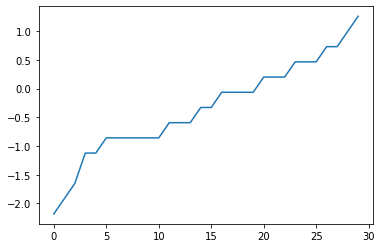

In [644]:
t = [-1.1227150654734128, 0.46603266868707677, -0.8579237764466646, -0.06354990936641965, 0.46603266868707677, -0.32834119839316783, 0.7308239577138252, -0.06354990936641965, 1.2604065357673218, -0.06354990936641965, 0.46603266868707677, -0.8579237764466646, -1.9170889325536575, -1.1227150654734128, -0.8579237764466646, -0.8579237764466646, -2.181880221580406, 0.20124137966032887, 0.7308239577138252, -0.5931324874199161, -0.06354990936641965, 0.9956152467405732, -0.5931324874199161, -0.8579237764466646, -0.8579237764466646, -1.6522976435269092, -0.5931324874199161, -0.32834119839316783, 0.20124137966032887, 0.20124137966032887]
plt.plot(sorted(t))